In [5]:
class Config():
  def __init__(
    self,
    num_classes,
    num_epochs,
    batch_size,
    learning_rate,
    early_stopping_patience,
    early_stopping_min_delta,
    use_saved_models,
    train_size,
    test_size,
    val_size,
    filename_prefix,
    poster_shape, # (height, width)
    trailer_shape, # (frames, height, width)
    trailer_frame_padding,
  ):
    self.num_classes = num_classes
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.early_stopping_patience = early_stopping_patience
    self.early_stopping_min_delta = early_stopping_min_delta

    self.use_saved_models = use_saved_models

    self.train_size = train_size
    self.test_size = test_size
    self.val_size = val_size

    self.filename_prefix = filename_prefix

    self.poster_shape = poster_shape

    self.trailer_shape = trailer_shape
    self.trailer_frame_padding = trailer_frame_padding

cfg = Config(
    num_classes=5,
    num_epochs=100, # Due to dropout
    batch_size = 32,
    learning_rate = 1e-3,
    early_stopping_patience = 5, # Due to dropout
    early_stopping_min_delta = 0.01,
    use_saved_models = False,
    train_size = 0.9,
    test_size = 0.05,
    val_size = 0.05,
    filename_prefix = '10_bor_poster_trailer_postreleased/',
    poster_shape = (268, 182),
    trailer_shape = (8, 96, 128),
    trailer_frame_padding = 0,
)

# Обработка данных

## Очистка

In [6]:
import pandas as pd
import numpy as np
from ast import literal_eval
from dateutil.parser import parse
from pathlib import Path

df = pd.read_csv('./movie_dataset.csv', index_col=0)

to_drop = [
    'id',
    'tagline',
    'overview',
    'vote_count',
    'original_title',
    'title',
    'spoken_languages',
    'original_language',
]
df = df.drop(columns=to_drop)

df['budget'] = df['budget'].replace({0: np.nan})
df['revenue'] = df['revenue'].replace({0: np.nan})
df['runtime'] = df['runtime'].replace({0: np.nan})

df.dropna(inplace=True)
df = df[df['status'] == 'Released']
df = df.drop(columns=['status'], axis=1)

literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors']

for col in literal_eval_cols:
    df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)

df['production_company'] = df.apply(lambda x: x['production_companies'][0], axis=1)
df['production_country'] = df.apply(lambda x: x['production_countries'][0], axis=1)
df = df.drop(columns=['production_companies', 'production_countries'], axis=1)

to_delete = ['M/PG', 'GP', 'Approved', 'M', 'Not Rated']
df = df[~df['mpaa'].isin(to_delete)]

df = df[df['actors'].map(len) == 3]
df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
df = df.drop(['actors'], axis=1)

m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
df = df.join(m.rename('release_month'))
df = df.drop(columns=['release_date'], axis=1)

posters = Path('./posters')
imdb_ids = [x.name[:-len('.jpg')] for x in posters.glob('*.jpg')]
df = df[df['imdb_id'].isin(imdb_ids)]
df['poster'] = df.apply(lambda x: f'./posters/{x["imdb_id"]}.jpg', axis=1)

trailers = Path('./trailers_8_96_128_0')
imdb_ids = [x.name[:-len('.npy')] for x in trailers.glob('*.npy')]
df = df[df['imdb_id'].isin(imdb_ids)]
df['trailer'] = df.apply(lambda x: f'./trailers_8_96_128_0/{x["imdb_id"]}.npy', axis=1)

df = df.drop(columns=['imdb_id'], axis=1)

<ipython-input-6-e727cea8166f>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['poster'] = df.apply(lambda x: f'./posters/{x["imdb_id"]}.jpg', axis=1)


In [7]:
df.shape

(3778, 17)

## Формирование целевой переменной

In [8]:
def get_class(row):
  R = row['revenue']
  if R <= 5000000:
    return 0
  elif 5000000 < R <= 25000000:
    return 1
  elif 25000000 < R <= 50000000:
    return 2
  elif 50000000 < R <= 125000000:
    return 3
  elif 125000000 < R:
    return 4
  return np.nan

df['target'] = df.apply(get_class, axis=1)
df = df.drop(columns=['revenue'], axis=1)

## Извлечение и преобразование признаков

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return

    def fit(self, X, y=None):
        # Жанры
        self.genres_mlb = MultiLabelBinarizer().fit(X['genres'].values)
        # Продюсерская компания
        self.production_company_encoder = LabelEncoder().fit(X['production_company'].values)
        # Страна производства
        self.production_country_encoder = LabelEncoder().fit(X['production_country'].values)
        # Дистрибьютор
        self.domestic_distributor_encoder = LabelEncoder().fit(X['domestic_distributor'].values)
        # Режиссер
        self.director_encoder = LabelEncoder().fit(X['director'].values)
        # Актеры
        unique_actors = pd.concat([df['actor_1'], df['actor_2'], df['actor_3']]).unique()
        self.actor_encoder = LabelEncoder().fit(unique_actors)
        # Месяц выхода
        self.release_month_encoder = OneHotEncoder(sparse_output=False).fit(X['release_month'].values.reshape(-1, 1))
        # Возрастной рейтинг
        self.mpaa_encoder = OneHotEncoder(sparse_output=False).fit(X['mpaa'].values.reshape(-1, 1))
        # Бюджет
        self.budget_scaler = StandardScaler().fit(X['budget'].values.reshape(-1, 1))
        # Длительность
        self.runtime_scaler = StandardScaler().fit(X['runtime'].values.reshape(-1, 1))
        # Средняя оценка
        self.vote_average_scaler = StandardScaler().fit(X['vote_average'].values.reshape(-1, 1))
        # Сборы в первый уикенд
        self.domestic_opening_scaler = StandardScaler().fit(X['domestic_opening'].values.reshape(-1, 1))

        self.columns_order = [
            'actor_1', 'actor_2', 'actor_3', 'director', 'production_company', 'production_country', 'domestic_distributor',
            'runtime', 'budget', 'vote_average', 'domestic_opening', 'poster', 'trailer',
            'genre_action', 'genre_adventure', 'genre_animation',
            'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
            'genre_family', 'genre_fantasy', 'genre_foreign', 'genre_history',
            'genre_horror', 'genre_music', 'genre_mystery', 'genre_romance',
            'genre_science_fiction', 'genre_thriller', 'genre_war', 'genre_western',
            'release_month_1', 'release_month_2', 'release_month_3',
            'release_month_4', 'release_month_5', 'release_month_6',
            'release_month_7', 'release_month_8', 'release_month_9',
            'release_month_10', 'release_month_11', 'release_month_12',
            'mpaa_G', 'mpaa_NC-17', 'mpaa_PG', 'mpaa_PG-13', 'mpaa_R'
        ]

        return self

    def transform(self, X):
        # Жанры
        classes = [f'genre_{x.replace(" ", "_").lower()}' for x in self.genres_mlb.classes_]
        transformed_genres = self.genres_mlb.transform(X['genres'].values)
        X = X.join(pd.DataFrame(transformed_genres.astype(bool), X.index, classes))
        X = X.drop(columns=['genres'], axis=1)
        # Продюсерская компания
        X['production_company'] = self.production_company_encoder.transform(X['production_company'].values)
        # Страна производства
        X['production_country'] = self.production_country_encoder.transform(X['production_country'].values)
        # Дистрибьютор
        X['domestic_distributor'] = self.domestic_distributor_encoder.transform(X['domestic_distributor'].values)
        # Режиссер
        X['director'] = self.director_encoder.transform(X['director'].values)
        # Актеры
        for i in range(1, 4):
            X[f'actor_{i}'] = self.actor_encoder.transform(X[f'actor_{i}'].values)
        # Месяц выхода
        classes = [f'release_month_{x}' for x in self.release_month_encoder.categories_[0]]
        transfored_release_month = self.release_month_encoder.transform(X['release_month'].values.reshape(-1, 1))
        X = X.join(pd.DataFrame(transfored_release_month.astype(bool), X.index, classes))
        X = X.drop(columns=['release_month'], axis=1)
        # Возрастной рейтинг
        classes = [('mpaa_' + x.upper()) for x in self.mpaa_encoder.categories_[0]]
        transfored_mpaa = self.mpaa_encoder.transform(X['mpaa'].values.reshape(-1, 1))
        X = X.join(pd.DataFrame(transfored_mpaa.astype(bool), X.index, classes))
        X = X.drop(columns=['mpaa'], axis=1)
        # Бюджет
        X['budget'] = self.budget_scaler.transform(X['budget'].values.reshape(-1, 1))
        # Длительность
        X['runtime'] = self.runtime_scaler.transform(X['runtime'].values.reshape(-1, 1))
        # Средняя оценка
        X['vote_average'] = self.vote_average_scaler.transform(X['vote_average'].values.reshape(-1, 1))
        # Сборы в первый уикенд
        X['domestic_opening'] = self.domestic_opening_scaler.transform(X['domestic_opening'].values.reshape(-1, 1))

        X = X[self.columns_order]

        return X

preprocess_pipeline = Pipeline(steps=[
    ('preprocessing', PreprocessingTransformer()),
])

X = df.drop(columns=['target'], axis=1)
y = df['target'].to_numpy()

# Fit and evaluate the model
X = preprocess_pipeline.fit_transform(X, y)

### Сохранение преобразования признаков

In [10]:
import dill

with open(f'{cfg.filename_prefix}pipeline.pkl', 'wb') as f:
    dill.dump(preprocess_pipeline, f, protocol=5)

# Построение и обучение моделей

## Вспомогательная функциональность

Опишем фукнцию, которая будет оценивать получившуюся модель

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

results = {}

# Функция для оценки полученной модели
def inspect_model(model, test_generator, y, model_name, history=None):
  predictions = model.predict(test_generator)
  # real_classes = y.argmax(axis=1)
  real_classes = y
  predicted_classes = predictions.argmax(axis=1)

  # Exact and 1-class-away accuracy
  real_classes = real_classes[:min(real_classes.shape[0], predicted_classes.shape[0])]
  predicted_classes = predicted_classes[:min(real_classes.shape[0], predicted_classes.shape[0])]
  diffs = abs(real_classes - predicted_classes)

  exact_match = len(diffs[diffs <= 0]) / len(diffs)
  one_class_away = len(diffs[diffs <= 1]) / len(diffs)
  print('Exact match accuracy:', exact_match)
  print('One class away accuracy:', one_class_away)

  # Precision and recall
  precision = precision_score(real_classes, predicted_classes, average=None)
  recall = recall_score(real_classes, predicted_classes, average=None)
  f1 = f1_score(real_classes, predicted_classes, average=None)
  print("Precision per class:", precision)
  print("Recall per class:", recall)
  print("F1 score per class", f1)

  # Macro and Micro averaged Precision and Recall
  macro_precision = precision_score(real_classes, predicted_classes, average='macro')
  macro_recall = recall_score(real_classes, predicted_classes, average='macro')
  micro_precision = precision_score(real_classes, predicted_classes, average='micro')
  micro_recall = recall_score(real_classes, predicted_classes, average='micro')
  macro_f1 = f1_score(real_classes, predicted_classes, average='macro')
  micro_f1 = f1_score(real_classes, predicted_classes, average='micro')

  print("Macro Precision:", macro_precision)
  print("Macro Recall:", macro_recall)
  print("Macro F1:", macro_f1)
  print("Micro Precision:", micro_precision)
  print("Micro Recall:", micro_recall)
  print("Micro F1:", micro_f1)

  # Confusion matrix
  m = confusion_matrix(real_classes, predicted_classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=m)
  disp.plot(cmap=plt.cm.gray_r)
  plt.show()

  if (history != None):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_loss'])
    ax.set_title('Loss Function Over Epochs')
    ax.set_ylabel('Sparse Categorical Crossentropy value')
    ax.set_xlabel('No. epoch')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Accuracy Over Epochs')
    ax.set_ylabel('Accuracy value')
    ax.set_xlabel('No. epoch')
    plt.show()

  results[model_name] = {
      'exact_match': exact_match,
      'one_class_away': one_class_away,
  }


Функция для извлечения фреймов из трейлера

In [12]:
import cv2

def extract_frames(
    trailer_path,
    num_frames=16,
    frame_size=(112, 112),
    frame_padding=0,
):
    """
    Extract frames from a video file.

    Args:
    - trailer_path (str): Path to the trailer file.
    - num_frames (int): Number of frames to extract (default is 16).
    - frame_size (tuple[int, int]): Resulting frame's size (default is (112, 112)).
    - frame_padding (int): How many frames to skip by both ends (default is 0).

    Returns:
    - frames (np.array): Array of extracted frames. Size: (16, *frame_size, 3)
    """

    height, width = frame_size

    # Open the video file
    cap = cv2.VideoCapture(trailer_path)
    frames = []

    # Get the total number of frames in the video (with respect to padding)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 2 * frame_padding

    # Calculate the interval at which frames will be extracted
    frame_interval = max(total_frames // num_frames, 1)

    # Iterate through the frames and extract them
    for i in range(num_frames):
        # Set the frame position to the current frame index
        cap.set(cv2.CAP_PROP_POS_FRAMES, (i * frame_interval) + frame_padding)

        # Read the frame
        ret, frame = cap.read()

        # Break the loop if the end of the video is reached
        if not ret:
            break

        # Resize the frame to `frame_size` pixels
        frame = cv2.resize(frame, (width, height))

        # Append the frame to the frames list
        frames.append(frame)

    # Release the video capture object
    cap.release()

    # Fill any missing frames with blank (zero) frames
    while len(frames) < num_frames:
        # print('filling missing frames with zeros')
        frames.append(np.zeros((height, width, 3), np.uint8))

    # Convert the frames list to a NumPy array
    return np.array(frames)

In [13]:
from tensorflow.keras.preprocessing import image
import cv2

def load_image(path, size):
    img = image.load_img(path)
    img = image.img_to_array(img)
    img = cv2.resize(img, size)
    return img

Опишем класс для генерации данных для таблично-постерной модели

In [14]:
from keras.utils import Sequence
from tensorflow.keras.preprocessing import image
import cv2

class TabularPosterTrailerGenerator(Sequence):
    def __init__(
        self,
        tabular,
        posters,
        trailers,
        labels,
        batch_size,
        poster_dim,
        trailer_dim,
        shuffle,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.tabular = tabular
        self.posters = posters
        self.trailers = trailers
        self.labels = labels
        self.poster_dim = poster_dim
        self.trailer_dim = trailer_dim
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.labels) / float(self.batch_size)))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Xt = np.empty((self.batch_size, self.tabular.shape[1]), dtype=np.float32)
        p_height, p_width = self.poster_dim
        Xp = np.empty((self.batch_size, p_height, p_width, 3), dtype=np.float32)
        num_frames, t_height, t_width = self.trailer_dim
        Xtr = np.empty((self.batch_size, num_frames, t_height, t_width, 3), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.int64)

        for i, idx in enumerate(indexes):
            Xt[i,] = self.tabular[idx]
            Xp[i,] = load_image(
                path=self.posters[idx],
                size=(p_width, p_height),
            )
            Xtr[i,] = np.load(self.trailers[idx])
            y[i] = self.labels[idx]

        return (Xt, Xp, Xtr), y

Кастомные слой для построения моделей

In [15]:
import tensorflow as tf
import keras

@keras.saving.register_keras_serializable()
class SliceLayer(keras.layers.Layer):
    def __init__(self, start_index, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.start_index = start_index

    def call(self, inputs):
        # Your custom slicing logic goes here
        return inputs[:, self.start_index:]

    def get_config(self):
        config = super(SliceLayer, self).get_config()
        config.update({
            "start_index": self.start_index,
        })
        return config

@keras.saving.register_keras_serializable()
class IndexAndExpandLayer(keras.layers.Layer):
    def __init__(self, index):
        super().__init__()
        self.index = index

    def call(self, inputs):
        return tf.expand_dims(inputs[:,self.index],-1)

    def get_config(self):
        return {
            "index": self.index,
        }


Кастомная метрика для отображения "1-class-away" точности

In [16]:
import tensorflow as tf

# Define the custom metric
@keras.saving.register_keras_serializable()
class OneClassAwayAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='one_class_away_accuracy', **kwargs):
        super(OneClassAwayAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class indices
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.squeeze(y_true)

        # Determine correct predictions within one class
        correct = tf.cast(
            tf.math.logical_or(
                tf.equal(y_true, y_pred),
                tf.logical_or(
                    tf.equal(y_true, y_pred + 1),
                    tf.equal(y_true, y_pred - 1)
                )
            ),
            tf.float32
        )

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            correct = tf.multiply(correct, sample_weight)

        self.total.assign_add(tf.reduce_sum(correct))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return tf.math.divide_no_nan(self.total, self.count)

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)

Расчет весов классов

In [17]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = {i: x for i, x in enumerate(class_weights)}

Разбиваем исходный датасет следующим образом: 90% - тренировочный, 5% - валидационный, 5% - тестовый.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_dum, y_train, y_dum = train_test_split(X, y, test_size=1-cfg.train_size, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_dum, y_dum, test_size=cfg.test_size/(cfg.test_size + cfg.val_size), stratify=y_dum)

print('Train size:', cfg.train_size)
print('Test size:', (1-cfg.train_size) * cfg.test_size/(cfg.test_size + cfg.val_size))
print('Val size:', (1-cfg.train_size) * cfg.val_size/(cfg.test_size + cfg.val_size))

print('Train size:', X_train.shape)
print('Test size:', X_test.shape)
print('Val size:', X_val.shape)

Train size: 0.9
Test size: 0.04999999999999999
Val size: 0.04999999999999999
Train size: (3400, 49)
Test size: (189, 49)
Val size: (189, 49)


## Архитектура табличной модели

In [19]:
import math
from keras import layers
from keras.models import Model
import tensorflow as tf

class AdditionalModel():
    def __init__(self, model, model_output, port, trainable):
        self.model = model
        self.model_output = model_output
        self.port = port
        self.trainable = trainable


def build_tabular_model(
    original_input_shape,
    n_unique_actors,
    n_unique_directors,
    n_unique_production_companies,
    n_unique_production_countries,
    n_unique_domestic_distributor,
    n_classes,
    poster_model: AdditionalModel,
    trailer_model: AdditionalModel,
):
    def out_dim(n):
        return math.ceil(math.pow(n, 0.25))

    def build_embedding_cfg(name, input_dim, output_dim):
        return {
            'name': name,
            'input_dim': input_dim,
            'output_dim': output_dim,
        }

    input = layers.Input(shape=(original_input_shape,))

    embedding_cfg = [
        build_embedding_cfg('actor_1', n_unique_actors, out_dim(n_unique_actors)),
        build_embedding_cfg('actor_2', n_unique_actors, out_dim(n_unique_actors)),
        build_embedding_cfg('actor_3', n_unique_actors, out_dim(n_unique_actors)),
        build_embedding_cfg('director', n_unique_directors, out_dim(n_unique_directors)),
        build_embedding_cfg('production_company', n_unique_production_companies, out_dim(n_unique_production_companies)),
        build_embedding_cfg('production_country', n_unique_production_countries, out_dim(n_unique_production_countries)),
        build_embedding_cfg('domestic_distributor', n_unique_domestic_distributor, out_dim(n_unique_domestic_distributor)),
    ]

    embedding_outputs = []
    for i, cfg in enumerate(embedding_cfg):
        embedded_lambda = IndexAndExpandLayer(i)(input)
        embedding = layers.Embedding(
            input_dim=cfg['input_dim'],
            output_dim=cfg['output_dim'],
            name=cfg['name'],
        )(embedded_lambda)
        output = layers.Flatten()(embedding)

        embedding_outputs.append(output)

    other_lambda = SliceLayer(len(embedding_cfg))(input)

    to_concat_input = [
        *embedding_outputs,
        other_lambda
    ]
    if (poster_model.port == 'input'):
        to_concat_input.append(poster_model.model_output)
    if (trailer_model.port == 'input'):
        to_concat_input.append(trailer_model.model_output)

    merged = layers.concatenate(to_concat_input)

    hidden = layers.Dense(64, activation='relu')(merged)
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(128, activation='relu')(hidden)
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(256, activation='relu')(hidden)

    to_concat_middle = [hidden]
    if (poster_model.port == 'middle'):
        to_concat_middle.append(poster_model.model_output)
    if (trailer_model.port == 'middle'):
        to_concat_middle.append(trailer_model.model_output)

    if (len(to_concat_middle) > 1):
        hidden = layers.concatenate(to_concat_middle)

    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(128, activation='relu')(hidden)
    hidden = layers.Dropout(0.6)(hidden)
    hidden = layers.Dense(64, activation='relu', name='output')(hidden)

    to_concat_output = [hidden]
    if (poster_model.port == 'output'):
        to_concat_output.append(poster_model.model_output)
    if (trailer_model.port == 'output'):
        to_concat_output.append(trailer_model.model_output)

    if (len(to_concat_output) > 1):
        hidden = layers.concatenate(to_concat_output)

    hidden = layers.Dropout(0.6)(hidden)

    output = layers.Dense(n_classes, activation='softmax')(hidden)

    inputs = [
        input,
        poster_model.model.input,
        trailer_model.model.input,
    ]

    poster_model.model.trainable = poster_model.trainable
    trailer_model.model.trainable = trailer_model.trainable

    model = Model(inputs=inputs, outputs=output)

    return model

## Архитектура модели для постеров

In [20]:
from keras import layers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.optimizers import Adagrad, Adam
import dill

class PosterModelWrapper():
    def __init__(self, input_shape, n_classes):
        inp = layers.Input(shape=input_shape)

        hidden = layers.Conv2D(64, 3, activation='relu')(inp)
        hidden = layers.Conv2D(64, 3, activation='relu')(hidden)
        hidden = layers.MaxPooling2D(pool_size=(2, 2))(hidden)

        hidden = layers.Conv2D(128, 3, activation="relu")(hidden)
        hidden = layers.Conv2D(128, 3, activation="relu")(hidden)
        hidden = layers.MaxPooling2D(pool_size=(2, 2))(hidden)

        hidden = layers.Conv2D(256, 3, activation="relu")(hidden)
        hidden = layers.Conv2D(256, 3, activation="relu")(hidden)
        hidden = layers.Conv2D(256, 3, activation="relu")(hidden)
        hidden = layers.MaxPooling2D(pool_size=(3, 3))(hidden)

        hidden = layers.Conv2D(512, 3, activation="relu")(hidden)
        hidden = layers.Conv2D(512, 3, activation="relu")(hidden)
        hidden = layers.Conv2D(512, 3, activation="relu")(hidden)

        hidden = layers.GlobalAveragePooling2D()(hidden)

        hidden = layers.Dense(128, activation='relu', name='poster_last')(hidden)

        out = layers.Dense(n_classes, activation='softmax')(hidden)

        model = Model(inputs=inp, outputs=out, name='poster')

        self.model = model

    def train(
        self,
        train_generator,
        val_generator,
        class_weights,
        epochs,
        checkpoint_path,
    ):
        optimizer = Adagrad(
            learning_rate=cfg.learning_rate,
        )
        self.model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy', OneClassAwayAccuracy()],
        )

        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
        # Настраиваем callback для ранней остановки модели
        early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience, verbose=1)
        # Настраиваем callback для TensorBoardd
        tensorboard = TensorBoard(log_dir="./logs")

        # Обучение модели
        full_history = self.model.fit(
            x=train_generator,
            validation_data=val_generator,
            epochs=epochs,
            verbose=1,
            callbacks=[
                checkpoint,
                early_stopping,
                tensorboard,
            ],
        )
        best_model = load_model(checkpoint_path)

        p = Path(checkpoint_path)
        with open(f'{p.parents[0]}/{p.stem}_history.pkl', 'wb') as f:
            dill.dump(full_history, f, protocol=5)

        return best_model, full_history

## Архитектура модели для трейлеров

In [21]:
from keras import layers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.optimizers import AdamW
import dill

class TrailerModelWrapper():
    def __init__(self, input_shape, n_classes):
        inp = layers.Input(shape=input_shape)

        # 3D convolutional layer with 64 filters, kernel size of (3, 3, 3), and ReLU activation
        hidden = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape)(inp)
        # 3D max pooling layer with pool size of (2, 2, 2)
        hidden = layers.MaxPooling3D((2, 2, 2))(hidden)
        # Batch normalization layer
        hidden = layers.BatchNormalization()(hidden)

        # Another 3D convolutional layer with 128 filters, kernel size of (3, 3, 3), and ReLU activation
        hidden = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(hidden)
        # Another 3D max pooling layer with pool size of (2, 2, 2)
        hidden = layers.MaxPooling3D((2, 2, 2))(hidden)
        # Another batch normalization layer
        hidden = layers.BatchNormalization()(hidden)

        # Another 3D convolutional layer with 256 filters, kernel size of (3, 3, 3), and ReLU activation
        hidden = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(hidden)
        # Another 3D max pooling layer with pool size of (2, 2, 2)
        hidden = layers.MaxPooling3D((2, 2, 2))(hidden)
        # Another batch normalization layer
        hidden = layers.BatchNormalization()(hidden)

        # Flatten layer to flatten the output of the convolutional layers
        hidden = layers.GlobalAveragePooling3D()(hidden)
        # Fully connected (dense) layer with 512 units and ReLU activation
        hidden = layers.Dense(512, activation='relu', name='trailer_last')(hidden)
        # Dropout layer with dropout rate of 0.5
        hidden = layers.Dropout(0.5)(hidden)
        # Output layer with softmax activation for multi-class classification
        out = layers.Dense(n_classes, activation='softmax')(hidden)

        self.model = Model(inputs=inp, outputs=out, name='trailer')

    def train(
        self,
        train_generator,
        val_generator,
        class_weights,
        epochs,
        checkpoint_path,
    ):
        optimizer = AdamW(
            learning_rate=cfg.learning_rate,
        )
        self.model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'],
        )

        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
        # Настраиваем callback для ранней остановки модели
        early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience, verbose=1)
        # Настраиваем callback для TensorBoardd
        tensorboard = TensorBoard(log_dir="./logs")

        # Обучение модели
        full_history = self.model.fit(
            x=train_generator,
            validation_data=val_generator,
            epochs=epochs,
            class_weight=class_weights,
            verbose=1,
            callbacks=[
                checkpoint,
                early_stopping,
                tensorboard,
            ],
        )

        p = Path(checkpoint_path)
        with open(f'{p.parents[0]}/{p.stem}_history.pkl', 'wb') as f:
            dill.dump(full_history, f, protocol=5)

        return self.model, full_history

### Архитектура

Params count: 7701573


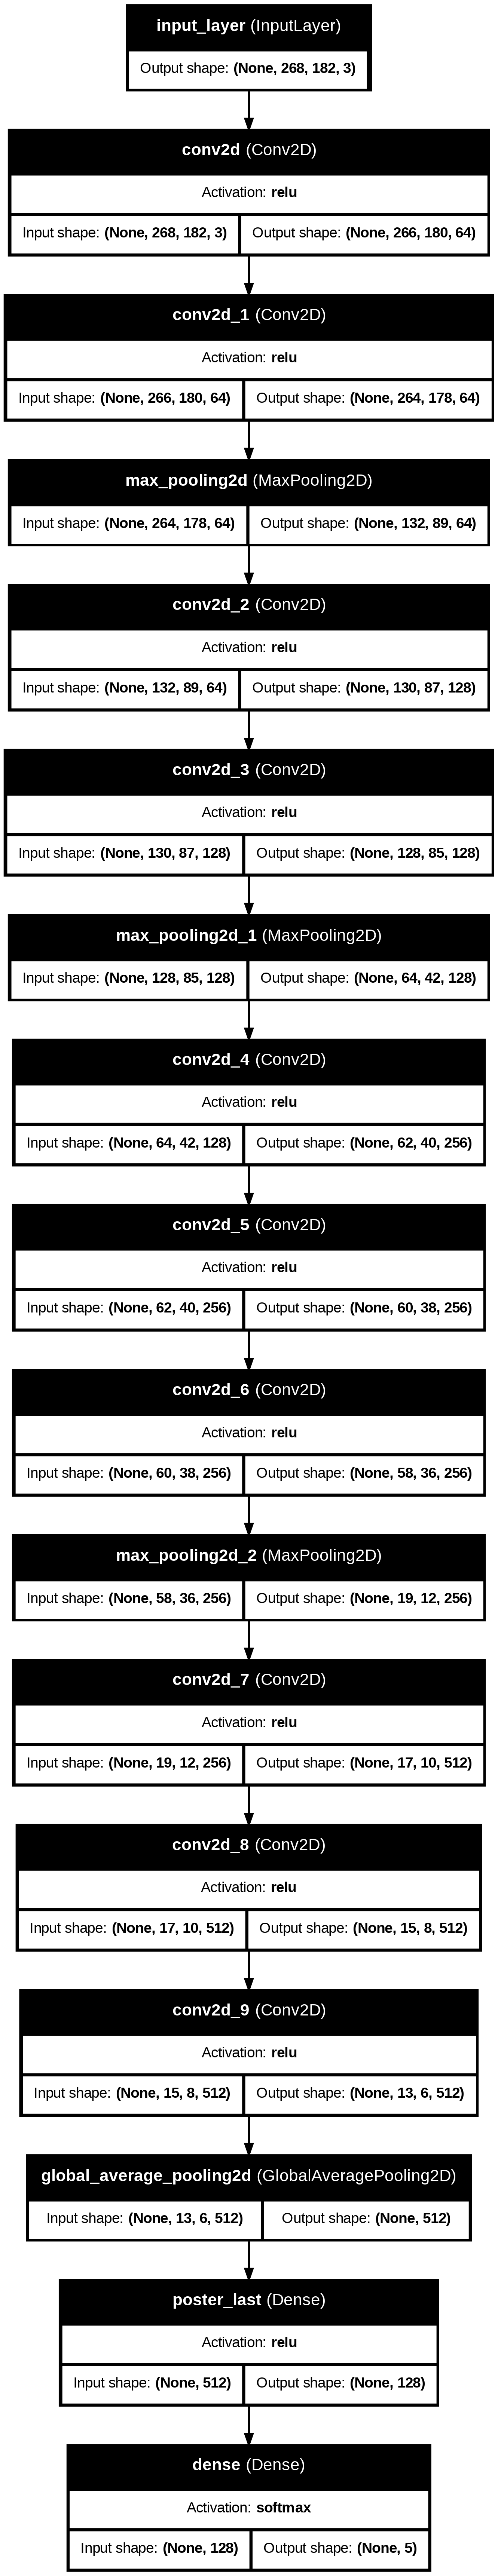

In [22]:
from keras.utils import plot_model

poster_model_wrapper = PosterModelWrapper(
    input_shape=(*cfg.poster_shape, 3),
    n_classes=cfg.num_classes,
)
print("Params count:", poster_model_wrapper.model.count_params())
plot_model(poster_model_wrapper.model, show_shapes=True, show_layer_activations=True, show_layer_names=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Params count: 1247493


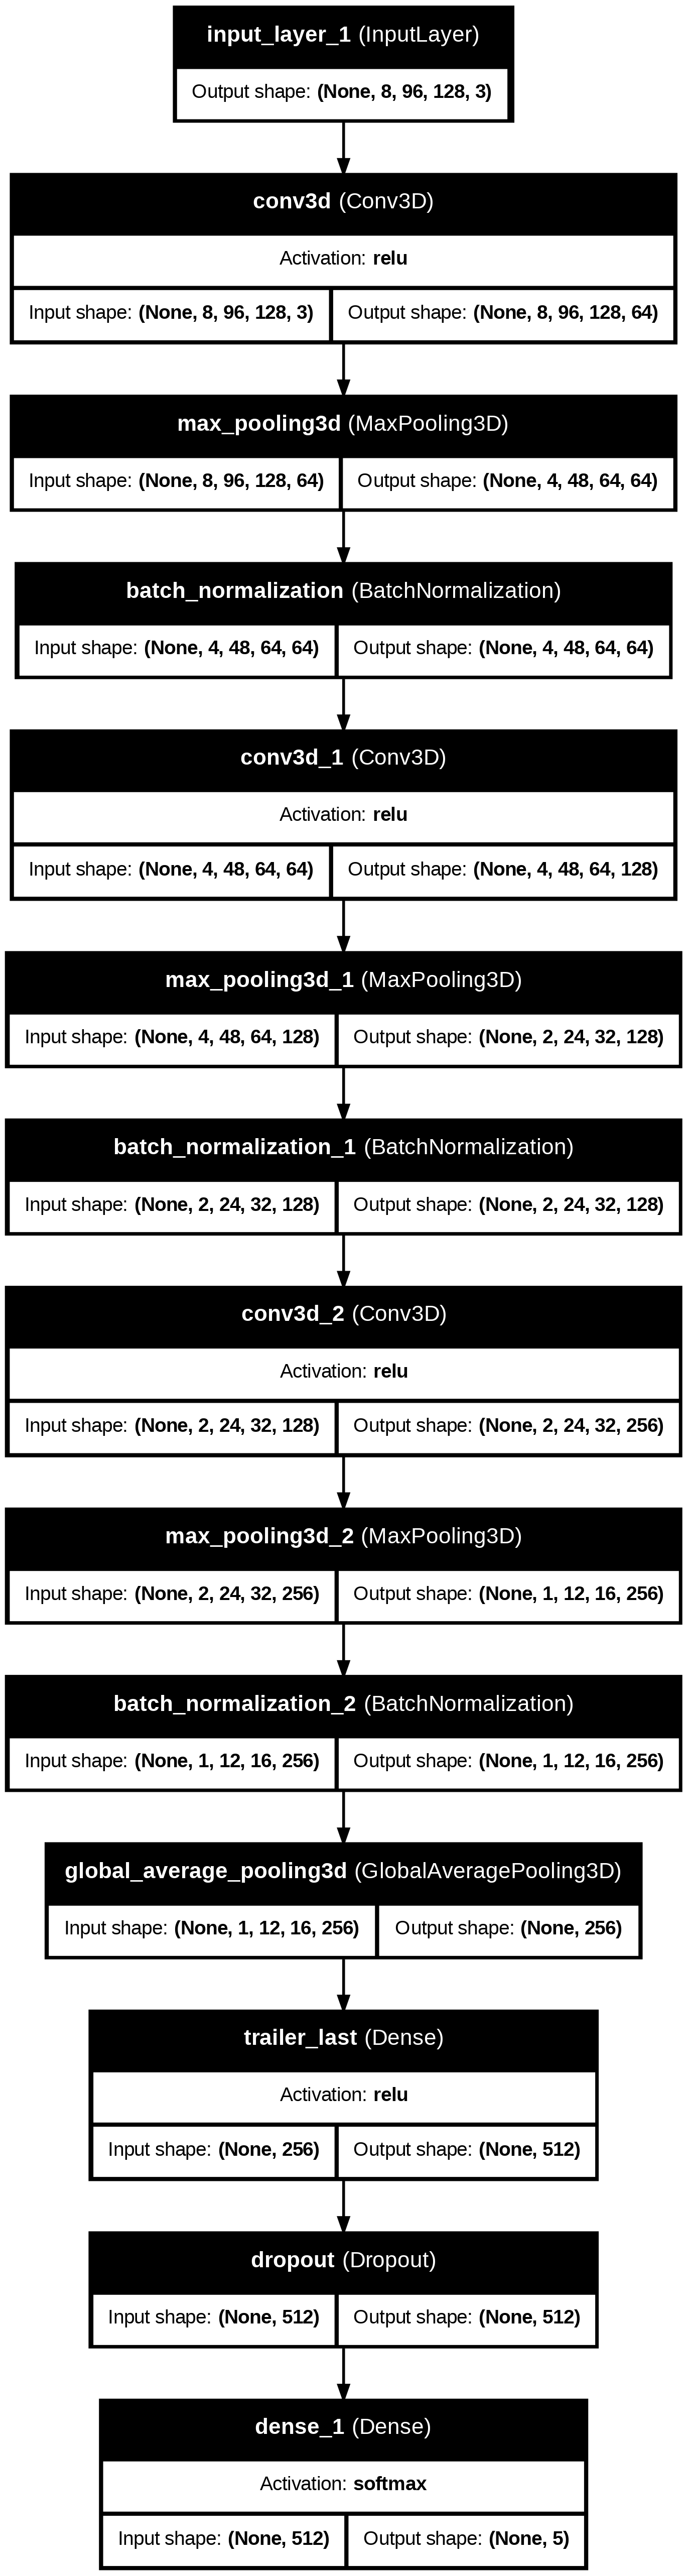

In [23]:
from keras.utils import plot_model

trailer_model_wrapper = TrailerModelWrapper(
    input_shape=(*cfg.trailer_shape, 3),
    n_classes=cfg.num_classes,
)
print("Params count:", trailer_model_wrapper.model.count_params())
plot_model(trailer_model_wrapper.model, show_shapes=True, show_layer_activations=True, show_layer_names=True)

In [24]:
def train(
    model,
    train_generator,
    val_generator,
    class_weights,
    checkpoint_path,
):
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    # Настраиваем callback для ранней остановки модели
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience, verbose=1)
    # Настраиваем callback для TensorBoardd
    tensorboard = TensorBoard(log_dir="./logs")

    # Обучение модели
    full_history = model.fit(
        x=train_generator,
        validation_data=val_generator,
        epochs=cfg.num_epochs,
        class_weight=class_weights,
        verbose=1,
        callbacks=[
            checkpoint,
            early_stopping,
            tensorboard,
        ],
    )

    p = Path(checkpoint_path)
    with open(f'{p.parents[0]}/{p.stem}_history.pkl', 'wb') as f:
        dill.dump(full_history, f, protocol=5)

    return model, full_history

## Обучение вместе

### Постер: выход, трейлер: выход

In [25]:
from keras.utils import plot_model

poster_model_wrapper = PosterModelWrapper(
    input_shape=(*cfg.poster_shape, 3),
    n_classes=cfg.num_classes,
)

trailer_model_wrapper = TrailerModelWrapper(
    input_shape=(*cfg.trailer_shape, 3),
    n_classes=cfg.num_classes,
)

OUTPUT_OUTPUT_model = build_tabular_model(
    original_input_shape=X.shape[1]-2,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    poster_model=AdditionalModel(
        model=poster_model_wrapper.model,
        model_output=poster_model_wrapper.model.get_layer("poster_last").output,
        port='output',
        trainable=True,
    ),
    trailer_model=AdditionalModel(
        model=trailer_model_wrapper.model,
        model_output=trailer_model_wrapper.model.get_layer("trailer_last").output,
        port='output',
        trainable=True,
    ),
)
plot_model(OUTPUT_OUTPUT_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
from keras.optimizers import AdamW

train_generator = TabularPosterTrailerGenerator(
    tabular=X_train.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_train['poster'].values,
    trailers=X_train['trailer'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=True,
)
val_generator = TabularPosterTrailerGenerator(
    tabular=X_val.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_val['poster'].values,
    trailers=X_val['trailer'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=False,
)

optimizer = Adam(
    learning_rate=cfg.learning_rate,
)
OUTPUT_OUTPUT_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

checkpoint_path = f'{cfg.filename_prefix}best_output_output_model.keras'
if (not Path(checkpoint_path).is_file()):
    best_model, full_history = train(
        model=OUTPUT_OUTPUT_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=checkpoint_path,
    )

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.2180 - loss: 4.5714
Epoch 1: val_loss improved from inf to 1.92971, saving model to 10_bor_poster_trailer_postreleased/best_output_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 141s 822ms/step - accuracy: 0.2182 - loss: 4.5516 - val_accuracy: 0.2188 - val_loss: 1.9297
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.3036 - loss: 1.5865
Epoch 2: val_loss improved from 1.92971 to 1.48408, saving model to 10_bor_poster_trailer_postreleased/best_output_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 73s 685ms/step - accuracy: 0.3038 - loss: 1.5859 - val_accuracy: 0.3875 - val_loss: 1.4841
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.3776 - loss: 1.4099
Epoch 3: val_loss improved from 1.48408 to 1.28886, saving model to 10_bor_poster_trailer_postreleased/best_output_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 685ms/step - accuracy: 0.3777 - loss: 1.4093 - val_accuracy: 

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step
Exact match accuracy: 0.55625
One class away accuracy: 0.925
Precision per class: [0.50909091 0.47058824 0.375      0.59375    0.78125   ]
Recall per class: [0.90322581 0.23529412 0.47368421 0.51351351 0.64102564]
F1 score per class [0.65116279 0.31372549 0.41860465 0.55072464 0.70422535]
Macro Precision: 0.5459358288770053
Macro Recall: 0.5533486578328284
Macro F1: 0.5276885843700758
Micro Precision: 0.55625
Micro Recall: 0.55625
Micro F1: 0.55625


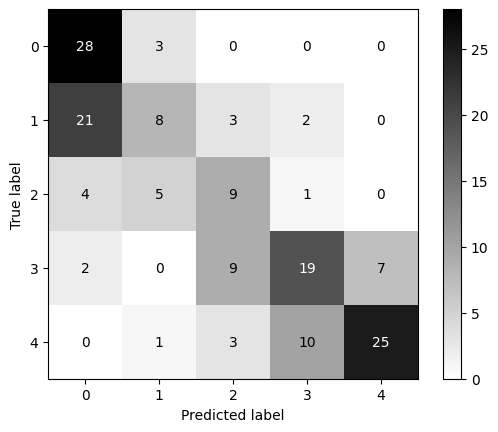

In [27]:
best_model = load_model(checkpoint_path)
# with open(f'{cfg.filename_prefix}best_output_output_model_history.pkl', 'rb') as f:
#     full_history = dill.load(f)

test_generator = TabularPosterTrailerGenerator(
    tabular=X_test.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_test['poster'].values,
    trailers=X_test['trailer'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=False,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, checkpoint_path, history=None)

## Обучение отдельно

In [28]:
best_poster_model = load_model('best_standalone_model.keras')
best_trailer_model = load_model('best_trailer_standalone_model.keras')

for layer in best_poster_model.layers:
    layer.name = layer.name + str("_XXX")

### Постер: промежуточный, трейлер: выход

In [29]:
from keras.utils import plot_model

poster_model_wrapper = PosterModelWrapper(
    input_shape=(*cfg.poster_shape, 3),
    n_classes=cfg.num_classes,
)

MIDDLE_pretrained_OUTPUT_model = build_tabular_model(
    original_input_shape=X.shape[1]-2,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    poster_model=AdditionalModel(
        model=poster_model_wrapper.model,
        model_output=poster_model_wrapper.model.get_layer("poster_last").output,
        port='middle',
        trainable=True,
    ),
    trailer_model=AdditionalModel(
        model=best_trailer_model,
        model_output=best_trailer_model.get_layer("last").output,
        port='output',
        trainable=False,
    ),
)
plot_model(MIDDLE_pretrained_OUTPUT_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [30]:
from keras.optimizers import AdamW

train_generator = TabularPosterTrailerGenerator(
    tabular=X_train.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_train['poster'].values,
    trailers=X_train['trailer'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=True,
)
val_generator = TabularPosterTrailerGenerator(
    tabular=X_val.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_val['poster'].values,
    trailers=X_val['trailer'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=False,
)

optimizer = Adam(
    learning_rate=cfg.learning_rate,
)
MIDDLE_pretrained_OUTPUT_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

checkpoint_path = f'{cfg.filename_prefix}best_middle_pretrained_output_model.keras'
if (not Path(checkpoint_path).is_file()):
    best_model, full_history = train(
        model=MIDDLE_pretrained_OUTPUT_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=checkpoint_path,
    )

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.2141 - loss: 2.5405
Epoch 1: val_loss improved from inf to 1.61021, saving model to 10_bor_poster_trailer_postreleased/best_middle_pretrained_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 65s 487ms/step - accuracy: 0.2142 - loss: 2.5342 - val_accuracy: 0.2000 - val_loss: 1.6102
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.2775 - loss: 1.6006
Epoch 2: val_loss improved from 1.61021 to 1.44960, saving model to 10_bor_poster_trailer_postreleased/best_middle_pretrained_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - accuracy: 0.2776 - loss: 1.6002 - val_accuracy: 0.3438 - val_loss: 1.4496
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.3592 - loss: 1.4492
Epoch 3: val_loss improved from 1.44960 to 1.28209, saving model to 10_bor_poster_trailer_postreleased/best_middle_pretrained_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 467ms/step - accuracy: 0.3594

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step
Exact match accuracy: 0.6125
One class away accuracy: 0.95
Precision per class: [0.67741935 0.48571429 0.40909091 0.65       0.78125   ]
Recall per class: [0.67741935 0.5        0.47368421 0.7027027  0.64102564]
F1 score per class [0.67741935 0.49275362 0.43902439 0.67532468 0.70422535]
Macro Precision: 0.6006949099287808
Macro Recall: 0.5989663818186738
Macro F1: 0.5977494791416739
Micro Precision: 0.6125
Micro Recall: 0.6125
Micro F1: 0.6125


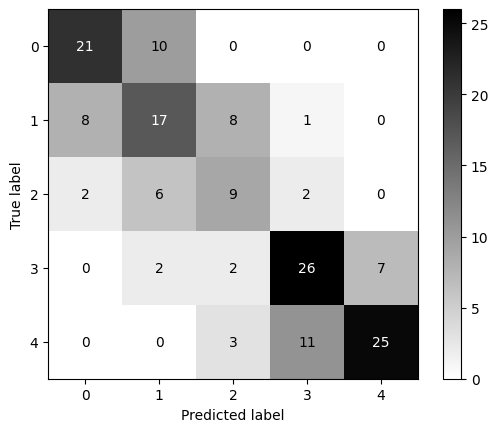

In [31]:
best_model = load_model(checkpoint_path)
# with open(f'{cfg.filename_prefix}best_output_output_model_history.pkl', 'rb') as f:
#     full_history = dill.load(f)

test_generator = TabularPosterTrailerGenerator(
    tabular=X_test.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_test['poster'].values,
    trailers=X_test['trailer'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=False,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, checkpoint_path, history=None)

### Постер: выход, трейлер: выход

In [33]:
from keras.utils import plot_model

poster_model_wrapper = PosterModelWrapper(
    input_shape=(*cfg.poster_shape, 3),
    n_classes=cfg.num_classes,
)

OUTPUT_pretrained_OUTPUT_model = build_tabular_model(
    original_input_shape=X.shape[1]-2,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    poster_model=AdditionalModel(
        model=poster_model_wrapper.model,
        model_output=poster_model_wrapper.model.get_layer("poster_last").output,
        port='output',
        trainable=True,
    ),
    trailer_model=AdditionalModel(
        model=best_trailer_model,
        model_output=best_trailer_model.get_layer("last").output,
        port='output',
        trainable=False,
    ),
)
plot_model(OUTPUT_pretrained_OUTPUT_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [34]:
from keras.optimizers import AdamW

train_generator = TabularPosterTrailerGenerator(
    tabular=X_train.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_train['poster'].values,
    trailers=X_train['trailer'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=True,
)
val_generator = TabularPosterTrailerGenerator(
    tabular=X_val.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_val['poster'].values,
    trailers=X_val['trailer'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=False,
)

optimizer = Adam(
    learning_rate=cfg.learning_rate,
)
OUTPUT_pretrained_OUTPUT_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

checkpoint_path = f'{cfg.filename_prefix}best_output_pretrained_output_model.keras'
if (not Path(checkpoint_path).is_file()):
    best_model, full_history = train(
        model=OUTPUT_pretrained_OUTPUT_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=checkpoint_path,
    )

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.2218 - loss: 4.0004
Epoch 1: val_loss improved from inf to 1.56729, saving model to 10_bor_poster_trailer_postreleased/best_output_pretrained_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 65s 489ms/step - accuracy: 0.2219 - loss: 3.9835 - val_accuracy: 0.2812 - val_loss: 1.5673
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.3233 - loss: 1.5280
Epoch 2: val_loss improved from 1.56729 to 1.32806, saving model to 10_bor_poster_trailer_postreleased/best_output_pretrained_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 72s 463ms/step - accuracy: 0.3235 - loss: 1.5275 - val_accuracy: 0.4062 - val_loss: 1.3281
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4156 - loss: 1.3305
Epoch 3: val_loss improved from 1.32806 to 1.20118, saving model to 10_bor_poster_trailer_postreleased/best_output_pretrained_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - accuracy: 0.4157

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step
Exact match accuracy: 0.55
One class away accuracy: 0.95
Precision per class: [0.53488372 0.4        0.2        0.64864865 0.8       ]
Recall per class: [0.74193548 0.41176471 0.15789474 0.64864865 0.61538462]
F1 score per class [0.62162162 0.4057971  0.17647059 0.64864865 0.69565217]
Macro Precision: 0.5167064739157763
Macro Recall: 0.5151256381257381
Macro F1: 0.5096380267735766
Micro Precision: 0.55
Micro Recall: 0.55
Micro F1: 0.55


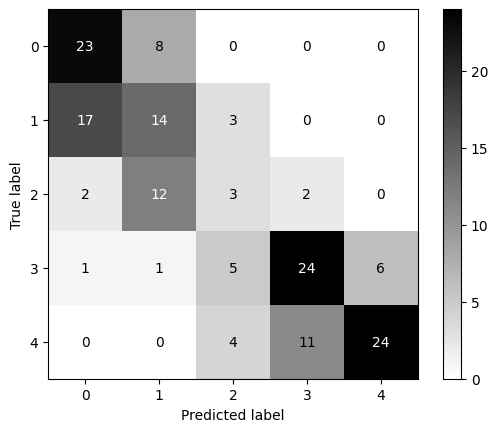

In [35]:
best_model = load_model(checkpoint_path)
# with open(f'{cfg.filename_prefix}best_output_output_model_history.pkl', 'rb') as f:
#     full_history = dill.load(f)

test_generator = TabularPosterTrailerGenerator(
    tabular=X_test.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_test['poster'].values,
    trailers=X_test['trailer'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=False,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, checkpoint_path, history=None)

### Постер: выход, трейлер: выход (все - предобучены)

In [36]:
from keras.utils import plot_model

pretrained_OUTPUT_pretrained_OUTPUT_model = build_tabular_model(
    original_input_shape=X.shape[1]-2,
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
    poster_model=AdditionalModel(
        model=best_poster_model,
        model_output=best_poster_model.get_layer("last_XXX").output,
        port='output',
        trainable=False,
    ),
    trailer_model=AdditionalModel(
        model=best_trailer_model,
        model_output=best_trailer_model.get_layer("last").output,
        port='output',
        trainable=False,
    ),
)
plot_model(pretrained_OUTPUT_pretrained_OUTPUT_model, show_shapes=True, show_layer_activations=True, show_layer_names=True, show_trainable=True)

In [37]:
from keras.optimizers import AdamW

train_generator = TabularPosterTrailerGenerator(
    tabular=X_train.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_train['poster'].values,
    trailers=X_train['trailer'].values,
    labels=y_train,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=True,
)
val_generator = TabularPosterTrailerGenerator(
    tabular=X_val.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_val['poster'].values,
    trailers=X_val['trailer'].values,
    labels=y_val,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=False,
)

optimizer = Adam(
    learning_rate=cfg.learning_rate,
)
pretrained_OUTPUT_pretrained_OUTPUT_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

checkpoint_path = f'{cfg.filename_prefix}best_truly_pretrained_output_pretrained_output_model.keras'
if (not Path(checkpoint_path).is_file()):
    best_model, full_history = train(
        model=pretrained_OUTPUT_pretrained_OUTPUT_model,
        train_generator=train_generator,
        val_generator=val_generator,
        class_weights=class_weights,
        checkpoint_path=checkpoint_path,
    )

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.2328 - loss: 1.6404
Epoch 1: val_loss improved from inf to 1.54456, saving model to 10_bor_poster_trailer_postreleased/best_truly_pretrained_output_pretrained_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - accuracy: 0.2329 - loss: 1.6403 - val_accuracy: 0.3063 - val_loss: 1.5446
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.3319 - loss: 1.4869
Epoch 2: val_loss improved from 1.54456 to 1.35229, saving model to 10_bor_poster_trailer_postreleased/best_truly_pretrained_output_pretrained_output_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 28s 265ms/step - accuracy: 0.3322 - loss: 1.4865 - val_accuracy: 0.3875 - val_loss: 1.3523
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.4138 - loss: 1.2966
Epoch 3: val_loss improved from 1.35229 to 1.18961, saving model to 10_bor_poster_trailer_postreleased/best_truly_pretrained_output_pretrained_output_model.keras
106/106 ━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step
Exact match accuracy: 0.55
One class away accuracy: 0.9125
Precision per class: [0.48888889 0.5        0.34782609 0.62068966 0.77419355]
Recall per class: [0.70967742 0.47058824 0.42105263 0.48648649 0.61538462]
F1 score per class [0.57894737 0.48484848 0.38095238 0.54545455 0.68571429]
Macro Precision: 0.5463196358809842
Macro Recall: 0.5406378776198011
Macro F1: 0.53518341307815
Micro Precision: 0.55
Micro Recall: 0.55
Micro F1: 0.55


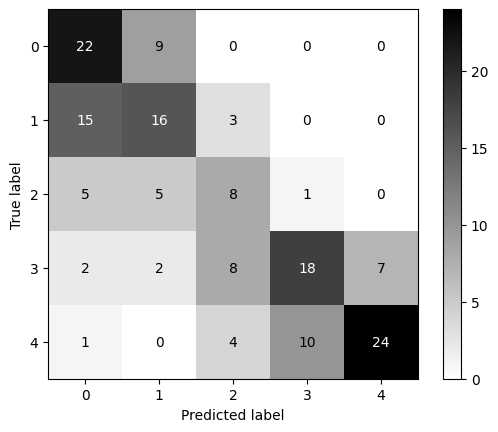

In [38]:
best_model = load_model(checkpoint_path)
# with open(f'{cfg.filename_prefix}best_output_output_model_history.pkl', 'rb') as f:
#     full_history = dill.load(f)

test_generator = TabularPosterTrailerGenerator(
    tabular=X_test.drop(columns=['trailer', 'poster'], axis=1).values,
    posters=X_test['poster'].values,
    trailers=X_test['trailer'].values,
    labels=y_test,
    batch_size=cfg.batch_size,
    poster_dim=cfg.poster_shape,
    trailer_dim=cfg.trailer_shape,
    shuffle=False,
)
# Проверка лучшей модели
inspect_model(best_model, test_generator, y_test, checkpoint_path, history=None)